In [4]:
# asume que los datos estan en ../data/<año>.csv.bz2
# fixme: poner el directorio de data que esté en el repo cuando pusheen los pibes

import seaborn as sns
import matplotlib.pyplot as plt

import fnmatch

import pandas as pd
import time
import os
import shutil
#sns.set(color_codes=True)
from sklearn.metrics import mean_squared_error

# load data
tmp_dir = "./tmp_csv/"
years = [str(year) for year in range(1994,2009)]
#years = [str(year) for year in range(1994,2005)]

## Procesar datos

In [ ]:
#crear directorio con data de delays agrupada por retraso 

# frequency = 'D' (diario) o 'M' (mensual)
def create_grouped_files(subdir, years, frequency):
    if not os.path.exists(tmp_dir):
        os.makedirs(tmp_dir)

    if not os.path.exists(tmp_dir + subdir):
        os.makedirs(tmp_dir + subdir)
    else: 
        return
    
    df_cut = pd.DataFrame(columns=["date", "ArrDelay"]).set_index("date")
    df_full = pd.DataFrame(columns=["date", "ArrDelay"]).set_index("date")
    for year in years:
        if not os.path.exists(tmp_dir+subdir+year+".csv"):
            print("Leyendo csv: {}".format(year))
            df = pd.read_csv("../data/"+year+".csv.bz2", compression="bz2", \
                             usecols=["Month", "Year", "DayofMonth", "DayOfWeek", "ArrDelay"], \
                             encoding="ISO 8859-1")    
        
            #formato mas feliz para fechas
            dates = pd.to_datetime(df.Year*10000+df.Month*100+df.DayofMonth, format='%Y%m%d')
            df["date"] = dates
            
            #acumulamos en full antes de recortar outliers
            df = df[["date", "ArrDelay"]]
            
            dg = df.groupby(pd.Grouper(key='date', freq=frequency)).mean()
            df_full = pd.concat([df_full, dg], sort=False)
            
            #sacamos outliers, nos quedamos con la mitad de los delays por bucket
            low = 0.1
            high = 0.9
            qiles = df.groupby(pd.Grouper(key='date', freq=frequency))["ArrDelay"].quantile([low, high]).unstack(level=1)
            mask =  (qiles.loc[df.date, low] < df.ArrDelay.values) & \
                    (df.ArrDelay.values < qiles.loc[df.date, high])
            df = df.loc[mask.values]

            #agrupamos
            df = df.groupby(by=df['date'].dt.date).mean()
            
            df.to_csv(tmp_dir+subdir+year+".csv")
            df_cut = pd.concat([df_cut, df], sort=False)
            del df 
            
    df_cut.to_csv(tmp_dir+subdir+"cut"+".csv")
    df_full.to_csv(tmp_dir+subdir+"full"+".csv")

create_grouped_files("daily/", years, 'D')
print("Listo ./tmp_csv/daily/")
create_grouped_files("monthly/", years, 'M')
print("Listo ./tmp_csv/monthly/")

In [ ]:
for filename in sorted(os.listdir(tmp_dir+"monthly/")):
    if filename.endswith(".csv") and filename not in ["cut.csv", "full.csv"]: 
        print(filename)
        df = pd.read_csv(tmp_dir+"monthly/"+filename)
        fig, ax = plt.subplots(figsize=(16,4))
        sns.lineplot(x=df.date, y=df.ArrDelay, linestyle='-')
        plt.xticks(plt.xticks()[0], df.date, rotation=90)
        plt.tight_layout()
        xticks = ax.xaxis.get_major_ticks()
        for i in range(len(xticks)):
            """
            if i%1 != 0:
                xticks[i].set_visible(True)            
            """
            if i%int((len(xticks))/4) == 0:    
                plt.axvline(x=i, color="orange")
            if i%int((len(xticks))/3) == 0:    
                plt.axvline(x=i, color="green")
        fig.autofmt_xdate()
        plt.show()
        
#Trimestres en verde, cuatrimestres en naranja

In [ ]:
df_daily_cut = pd.read_csv(tmp_dir+"daily/cut.csv")
print(df_daily_cut)
df_daily_cut.plot(x="date", y="ArrDelay", linestyle='-', figsize=(16,4), title = "acumulado diario sin outliers")

df_daily_full = pd.read_csv(tmp_dir+"daily/full.csv")
df_daily_full.plot(x="date", y="ArrDelay", linestyle='-', figsize=(16,4), title = "acumulado diario con outliers")

In [ ]:
df_monthly_cut = pd.read_csv(tmp_dir+"monthly/cut.csv")
df_monthly_cut.plot(x="date", y="ArrDelay", linestyle='-', figsize=(16,4), title = "acumulado mensual sin outliers")

df_monthly_full = pd.read_csv(tmp_dir+"monthly/full.csv")
df_monthly_full.plot(x="date", y="ArrDelay", linestyle='-', figsize=(16,4), title = "acumulado mensual con outliers")

# CML acá 
## Diario

In [6]:
#del df
df = pd.read_csv(tmp_dir+"daily/full.csv")
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df.sort_values(by="date")

year_train_limit = 2007
lower_year_train_limit = 1994

train_delays = df.loc[(df["date"].dt.year < year_train_limit) & \
                      (df["date"].dt.year > lower_year_train_limit)]["ArrDelay"]
print(len(train_delays))
print(len(df["ArrDelay"]))

4383
5479


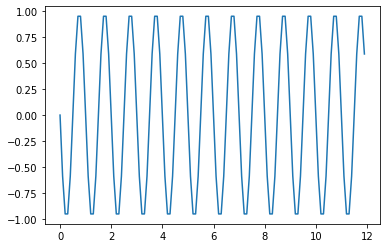

In [7]:
#para jugar con fases
import numpy as np
import math

time        = np.arange(0, 12, 0.1);
amplitude   = np.sin(2 * math.pi / 1* time + math.pi)
plt.plot(time, amplitude)
plt.show()

In [8]:
def nrmse(pred,y):
    return math.sqrt(mean_squared_error(pred, y)) / (y.max()-y.min())

max_grade = 1
phases = [i*math.pi/2 for i in range(4)]
monthly_freqs =  [3, 4, 6, 12]
# semanas, meses, bimestres, trimestres, cuatrimestres, semestres, años
daily_freqs =  [7] + [355/i for i in [12, 6, 4, 3, 2, 1]] 

class lsqPredictor:
    def __init__(self, phases, freqs, max_grade):
        self.phases = phases
        self.freqs = freqs
        self.max_grade = max_grade
    
    def trig_vals(self, t):
        return  [math.sin(2 * math.pi / f * t + p) for f in self.freqs for p in self.phases]

    def get_x_vals(self, x):
        x_vals = []
        for i in range(len(x)):
            row = np.array([i**p for p in range(self.max_grade+1)] + self.trig_vals(i), dtype='float')
            x_vals.append(row)
        return x_vals
    
    def print_coefs(self):
        c = 0
        for i in range(self.max_grade+1):
            print("Coef de x^{}:\n{}".format(i, self.coefs[c]))
            c += 1
        for i in self.freqs:
            for j in self.phases:
                print("Coef de sinusoide con frecuencia {} y fase {}:\n{}".format(i, j, self.coefs[c]))
                c += 1
                
    def fit(self, train_set):
        arrays = self.get_x_vals(train_set)
        A = np.stack(arrays)
        self.coefs = np.linalg.solve(A.T@A, A.T@train_set)
    
    def pred(self, pred_set):
        arrays = self.get_x_vals(pred_set)
        full_A = np.stack(arrays)        
        return full_A@self.coefs 
    
lpr = lsqPredictor(phases, daily_freqs, max_grade)
lpr.fit(train_delays)
lpr.print_coefs()

Coef de x^0:
8.18195166791727
Coef de x^1:
-0.0005154969359442922
Coef de sinusoide con frecuencia 7 y fase 0.0:
50.84233092802256
Coef de sinusoide con frecuencia 7 y fase 1.5707963267948966:
-47.83690826499263
Coef de sinusoide con frecuencia 7 y fase 3.141592653589793:
51.68034189242733
Coef de sinusoide con frecuencia 7 y fase 4.71238898038469:
-46.53713503615573
Coef de sinusoide con frecuencia 29.583333333333332 y fase 0.0:
349.5195029370157
Coef de sinusoide con frecuencia 29.583333333333332 y fase 1.5707963267948966:
-883.6801084646029
Coef de sinusoide con frecuencia 29.583333333333332 y fase 3.141592653589793:
349.36151376289786
Coef de sinusoide con frecuencia 29.583333333333332 y fase 4.71238898038469:
-883.4509803921569
Coef de sinusoide con frecuencia 59.166666666666664 y fase 0.0:
-212.3733214626214
Coef de sinusoide con frecuencia 59.166666666666664 y fase 1.5707963267948966:
-4.934578606110111
Coef de sinusoide con frecuencia 59.166666666666664 y fase 3.141592653589793

In [9]:
if "dl_pred" in df:
    del df["dl_pred"]

In [10]:
train_test_delays = df["ArrDelay"]

df["dl_pred"] = lpr.pred(train_test_delays) 
df.describe()

,ArrDelay,dl_pred
count,5479.000000,5479.000000
mean,7.241327,6.773049
std,7.327431,1.590079
min,-19.000000,2.103281
25%,2.095552,5.650404
50%,5.977256,6.804066
75%,10.878614,7.922866
max,67.904927,10.821473


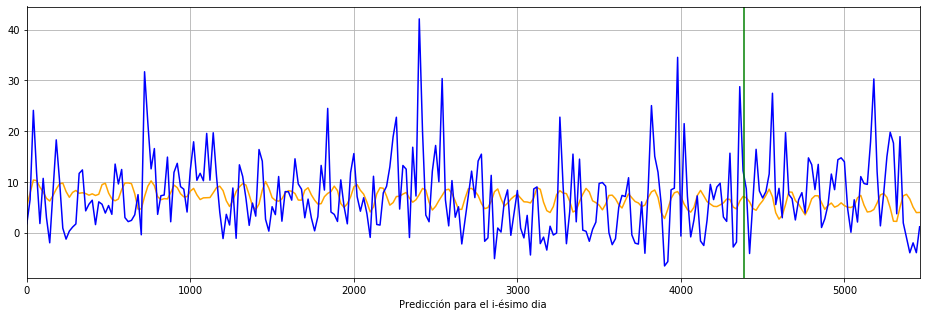

In [11]:
#df.plot(x="date", y=["DepDelay", "dl_pred"], figsize=(16,5))

def plot_df(df1, df2, train_limit_axis, unit_str):
    plt.figure(figsize=(16,5))
    plt.xlabel('Predicción para el i-ésimo {}'.format(unit_str))

    df2 = df2[df2.index % 20 == 0] 
    df1 = df1[df1.index % 20 == 0] 
    
    ax1 = df1.dl_pred.plot(color='orange', grid=True, label='pred delay')
    df2.ArrDelay.plot(color='blue', grid=True, secondary_y=False, label='real delay', ax=ax1)

    xticks = ax1.xaxis.get_major_ticks()
    plt.axvline(x=train_limit_axis, color="green")
    plt.show()

df_full = pd.read_csv(tmp_dir+"daily/full.csv")
df_full['date'] = pd.to_datetime(df_full['date'], errors='coerce')
plot_df(df, df_full, len(train_delays), "dia")

In [12]:
nrmse(
    df.loc[df["date"].dt.year>year_train_limit].dl_pred, 
    df_full.loc[df_full["date"].dt.year>year_train_limit].ArrDelay
)

0.19978469406142363

## Mensual

In [ ]:
del df

In [13]:
df = pd.read_csv(tmp_dir+"monthly/cut.csv")
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df.sort_values(by="date")
year_train_limit = 2002
lower_year_train_limit = 1994
train_delays = df.loc[(df["date"].dt.year < year_train_limit) & \
                      (df["date"].dt.year > lower_year_train_limit)]["ArrDelay"]

lpr = lsqPredictor(phases, monthly_freqs, max_grade)
lpr.fit(train_delays)
lpr.print_coefs()

Coef de x^0:
3.758494790609105
Coef de x^1:
-0.02519791791533863
Coef de sinusoide con frecuencia 3 y fase 0.0:
38.24307627260972
Coef de sinusoide con frecuencia 3 y fase 1.5707963267948966:
-208.17468249905454
Coef de sinusoide con frecuencia 3 y fase 3.141592653589793:
38.69349617118031
Coef de sinusoide con frecuencia 3 y fase 4.71238898038469:
-208.17826149715216
Coef de sinusoide con frecuencia 4 y fase 0.0:
-4900.39151428158
Coef de sinusoide con frecuencia 4 y fase 1.5707963267948966:
284.35559118106005
Coef de sinusoide con frecuencia 4 y fase 3.141592653589793:
-4900.56963439131
Coef de sinusoide con frecuencia 4 y fase 4.71238898038469:
285.13955709724655
Coef de sinusoide con frecuencia 6 y fase 0.0:
153.79834574039663
Coef de sinusoide con frecuencia 6 y fase 1.5707963267948966:
147.80212230243876
Coef de sinusoide con frecuencia 6 y fase 3.141592653589793:
154.74246900090293
Coef de sinusoide con frecuencia 6 y fase 4.71238898038469:
145.99461325621942
Coef de sinusoide c

In [14]:
if "dl_pred" in df:
    del df["dl_pred"]

In [15]:
train_test_delays = df["ArrDelay"]

df["dl_pred"] = lpr.pred(train_test_delays) 

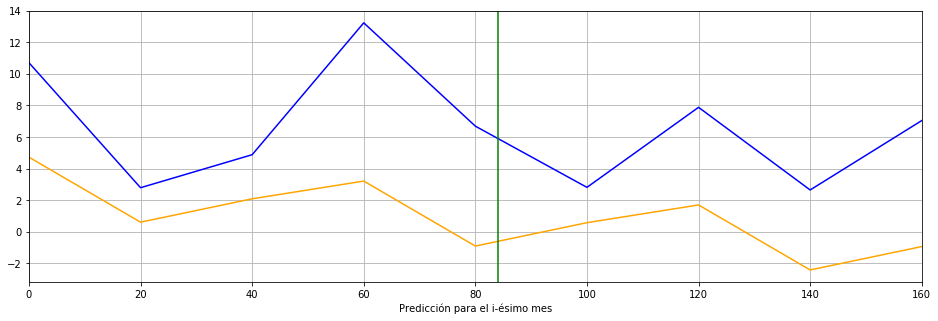

In [16]:
df_full = pd.read_csv(tmp_dir+"monthly/full.csv")
df_full['date'] = pd.to_datetime(df_full['date'], errors='coerce')
plot_df(df, df_full, len(train_delays), "mes")

In [17]:
nrmse(
    df.loc[df["date"].dt.year>year_train_limit].dl_pred, 
    df_full.loc[df_full["date"].dt.year>year_train_limit].ArrDelay
)

0.4730693760113268

## BORRAR ARCHIVOS

In [ ]:
#borrar aux de años
for filename in os.listdir(tmp_dir):
    if fnmatch.fnmatch(filename, '*.csv') and filename != "merged.csv":
        os.remove(tmp_dir+filename)

In [ ]:
#borrar merged
os.remove(tmp_dir+"merged.csv")

In [ ]:
#borrar tmp
shutil.rmtree(tmp_dir)